<a href="https://colab.research.google.com/github/Vibhadsouza26/Amazon-Product-Recommender/blob/main/Amazon2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Section 1: Requirements and Setup
# -------------------------------
!pip install pandas matplotlib seaborn scikit-learn wordcloud textblob lightfm plotly dash



In [36]:
# Section 2: Imports and Configuration
# -----------------------------------
import pandas as pd
import numpy as np
import re
import warnings
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import logging

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
logging.basicConfig(filename='pipeline.log', level=logging.INFO)

# Initialize progress tracking
progress = defaultdict(bool)  # Track each step's success


In [61]:
import pandas as pd
from typing import Optional
import logging

# Initialize progress tracking with explicit key management
progress = {'data_load': False}

def load_and_validate_data(file_path: str) -> Optional[pd.DataFrame]:
    """
    Load and validate CSV data with comprehensive error handling

    Args:
        file_path: Path to the CSV file

    Returns:
        DataFrame if successful, None otherwise
    """
    try:
        # Verify file existence first
        try:
            with open(file_path, 'rb'):
                pass
        except FileNotFoundError:
            raise FileNotFoundError(f"CSV file not found at: {file_path}")

        # Load data with dtype validation
        df = pd.read_csv(file_path)

        # Validate data is not empty
        if df.empty:
            raise ValueError("Loaded CSV file is empty")

        # Verify essential columns exist
        required_columns = ['product_id', 'user_id', 'rating']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

        # Log and track success
        progress['data_load'] = True
        logging.info(f"✅ Data loaded successfully: {len(df)} records, {len(df.columns)} columns")
        print(f"✅ Data loaded successfully with {len(df)} records")
        print(f"   Columns: {list(df.columns)}")

        return df

    except FileNotFoundError as e:
        error_msg = f"❌ File not found: {str(e)}"
    except pd.errors.EmptyDataError:
        error_msg = "❌ CSV file is empty or contains no valid data"
    except pd.errors.ParserError:
        error_msg = "❌ Invalid CSV format detected"
    except ValueError as ve:
        error_msg = f"❌ Validation error: {str(ve)}"
    except Exception as e:
        error_msg = f"❌ Unexpected error: {str(e)}"

    # Unified error handling
    if 'error_msg' in locals():
        progress['data_load'] = False
        logging.error(error_msg)
        print(error_msg)
        return None

# Usage with proper error handling
try:
    df = load_and_validate_data('amazon.csv')
    if df is None:
        raise SystemExit("Data loading failed. Exiting...")
except SystemExit as e:
    print(e)
    raise

✅ Data loaded successfully with 1465 records
   Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']


In [71]:
import pandas as pd
import numpy as np
import re
import logging
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Initialize logging
logging.basicConfig(level=logging.INFO)

progress = {'eda': False, 'preprocessing': False}

def preprocess_data(df):
    try:
        # Price cleaning with error handling
        def clean_price(col):
            return pd.to_numeric(
                df[col].astype(str)
                   .str.replace(r'[^\d.]', '', regex=True)
                   .replace('', '0'),
                errors='coerce'
            ).fillna(0)

        df['discounted_price'] = clean_price('discounted_price')
        df['actual_price'] = clean_price('actual_price')

        # Calculate discount percentage safely
        df['discount_percentage'] = np.where(
            df['actual_price'] > 0,
            ((df['actual_price'] - df['discounted_price']) / df['actual_price']) * 100,
            0
        )

        # Enhanced rating cleaning
        def clean_rating(rating):
            try:
                parts = str(rating).split('|')
                valid_ratings = []
                for part in parts:
                    # Extract first valid number from each part
                    cleaned = re.sub(r'^\D*([\d.]+).*', r'\1', part.strip())
                    if cleaned.replace('.', '', 1).isdigit():
                        valid_ratings.append(float(cleaned))
                return sum(valid_ratings)/len(valid_ratings) if valid_ratings else np.nan
            except:
                return np.nan

        df['rating'] = df['rating'].apply(clean_rating)
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

        # Impute missing ratings with median
        median_rating = df['rating'].median()
        df['rating'] = df['rating'].fillna(median_rating)

        # Review expansion logic remains unchanged
        # ... [keep your existing review expansion code here] ...

        # Final validation
        required_cols = ['product_id', 'user_id', 'rating']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        progress['preprocessing'] = True
        logging.info(f"Preprocessing completed. Shape: {df.shape}")
        return df

    except Exception as e:
        progress['preprocessing'] = False
        logging.error(f"Preprocessing failed: {str(e)}")
        return df

def perform_eda(df):
    try:
        print("\n📊 Starting Exploratory Data Analysis")

        # Validate numeric columns
        numeric_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Show statistics
        print("\nDescriptive Statistics:")
        print(df[numeric_cols].describe())

        # Check non-numeric ratings (excluding NaN)
        valid_ratings = df['rating'].dropna()
        non_numeric = valid_ratings[~valid_ratings.apply(
            lambda x: str(x).replace('.', '', 1).isdigit() if x else False
        )]

        if not non_numeric.empty:
            count = len(non_numeric)
            logging.warning(f"Non-numeric ratings found: {count}")
            print(f"⚠️ Warning: {count} non-numeric ratings detected")
        else:
            print("✅ All ratings are numeric")

        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Rating distribution
        sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0,0])
        axes[0,0].set_title('Rating Distribution')

        # Correlation heatmap
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=axes[0,1])
        axes[0,1].set_title('Feature Correlations')

        # Top categories
        if 'category' in df.columns:
            df['category'].value_counts().head(10).plot(
                kind='bar', ax=axes[1,0]
            ).set_title('Top 10 Categories')
        else:
            axes[1,0].text(0.5, 0.5, 'No category data', ha='center')

        # Word cloud
        if 'about_product' in df.columns:
            text = ' '.join(df['about_product'].dropna().astype(str))
            WordCloud(background_color='white').generate(text).to_image()
            axes[1,1].imshow(WordCloud().generate(text))
            axes[1,1].axis('off')
            axes[1,1].set_title('Product Descriptions')
        else:
            axes[1,1].text(0.5, 0.5, 'No description data', ha='center')

        plt.tight_layout()
        plt.show()

        progress['eda'] = True
        logging.info("EDA completed successfully")

    except Exception as e:
        progress['eda'] = False
        logging.error(f"EDA failed: {str(e)}")
        print(f"❌ EDA Error: {str(e)}")

In [72]:
df = preprocess_data(df)
if not progress.get('preprocessing'):
    raise SystemExit("Preprocessing failed. Exiting...")


In [73]:
def perform_eda(df):
    try:
        print("\n📊 Starting Exploratory Data Analysis")

        # Validate numeric columns
        numeric_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating']
        for col in numeric_cols:
            if not pd.api.types.is_numeric_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Summary statistics with error handling
        print("\nDescriptive Statistics:")
        stats_df = df[numeric_cols].describe(include='all')
        print(stats_df)

        # Identify non-numeric ratings
        non_numeric_ratings = df[~df['rating'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
        if not non_numeric_ratings.empty:
            logging.warning(f"Found {len(non_numeric_ratings)} non-numeric ratings")
            print(f"⚠️ Warning: {len(non_numeric_ratings)} non-numeric ratings detected")

        # Visualizations with enhanced error handling
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Rating distribution with validation
        valid_ratings = df[pd.to_numeric(df['rating'], errors='coerce').notnull()]['rating']
        sns.countplot(x=valid_ratings, ax=axes[0,0])
        axes[0,0].set_title('Rating Distribution (Valid Values)')

        # Correlation heatmap with validation
        valid_numeric = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
        sns.heatmap(valid_numeric.corr(), annot=True, cmap='coolwarm', ax=axes[0,1])
        axes[0,1].set_title('Feature Correlation Heatmap')

        # Top categories with error handling
        if 'category' in df.columns:
            top_categories = df['category'].value_counts().head(10)
            top_categories.plot(kind='bar', ax=axes[1,0])
            axes[1,0].set_title('Top 10 Categories')
        else:
            axes[1,0].text(0.5, 0.5, 'Category data missing', ha='center')

        # Word cloud with content validation
        if 'about_product' in df.columns and not df['about_product'].isnull().all():
            all_descriptions = ' '.join(
                df['about_product']
                .fillna('')
                .astype(str)
                .apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
            )
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=100
            ).generate(all_descriptions)

            axes[1,1].imshow(wordcloud, interpolation='bilinear')
            axes[1,1].axis('off')
            axes[1,1].set_title('Product Descriptions Word Cloud')
        else:
            axes[1,1].text(0.5, 0.5, 'No product descriptions available', ha='center')

        plt.tight_layout()
        plt.show()

        progress['eda'] = True
        logging.info("EDA completed successfully")
        print("✅ EDA completed successfully")

    except Exception as e:
        progress['eda'] = False
        error_msg = f"EDA failed: {str(e)}"
        logging.error(error_msg)
        print(f"❌ {error_msg}")
        # Additional debug information
        print("\nProblematic columns:")
        for col in numeric_cols:
            print(f"- {col}: {df[col].apply(type).unique()}")


📊 Starting Exploratory Data Analysis

Descriptive Statistics:
       discounted_price   actual_price  discount_percentage        rating
count      11503.000000   11503.000000         11503.000000  11503.000000
mean        3009.465656    5254.438950            47.726178      4.097818
std         6694.994950   10443.428608            21.601797      0.281835
min           39.000000      39.000000             0.000000      2.000000
25%          320.000000     800.000000            32.313117      4.000000
50%          799.000000    1630.000000            50.016672      4.100000
75%         1999.000000    4200.000000            62.925852      4.300000
max        77990.000000  139900.000000            94.118824      5.000000


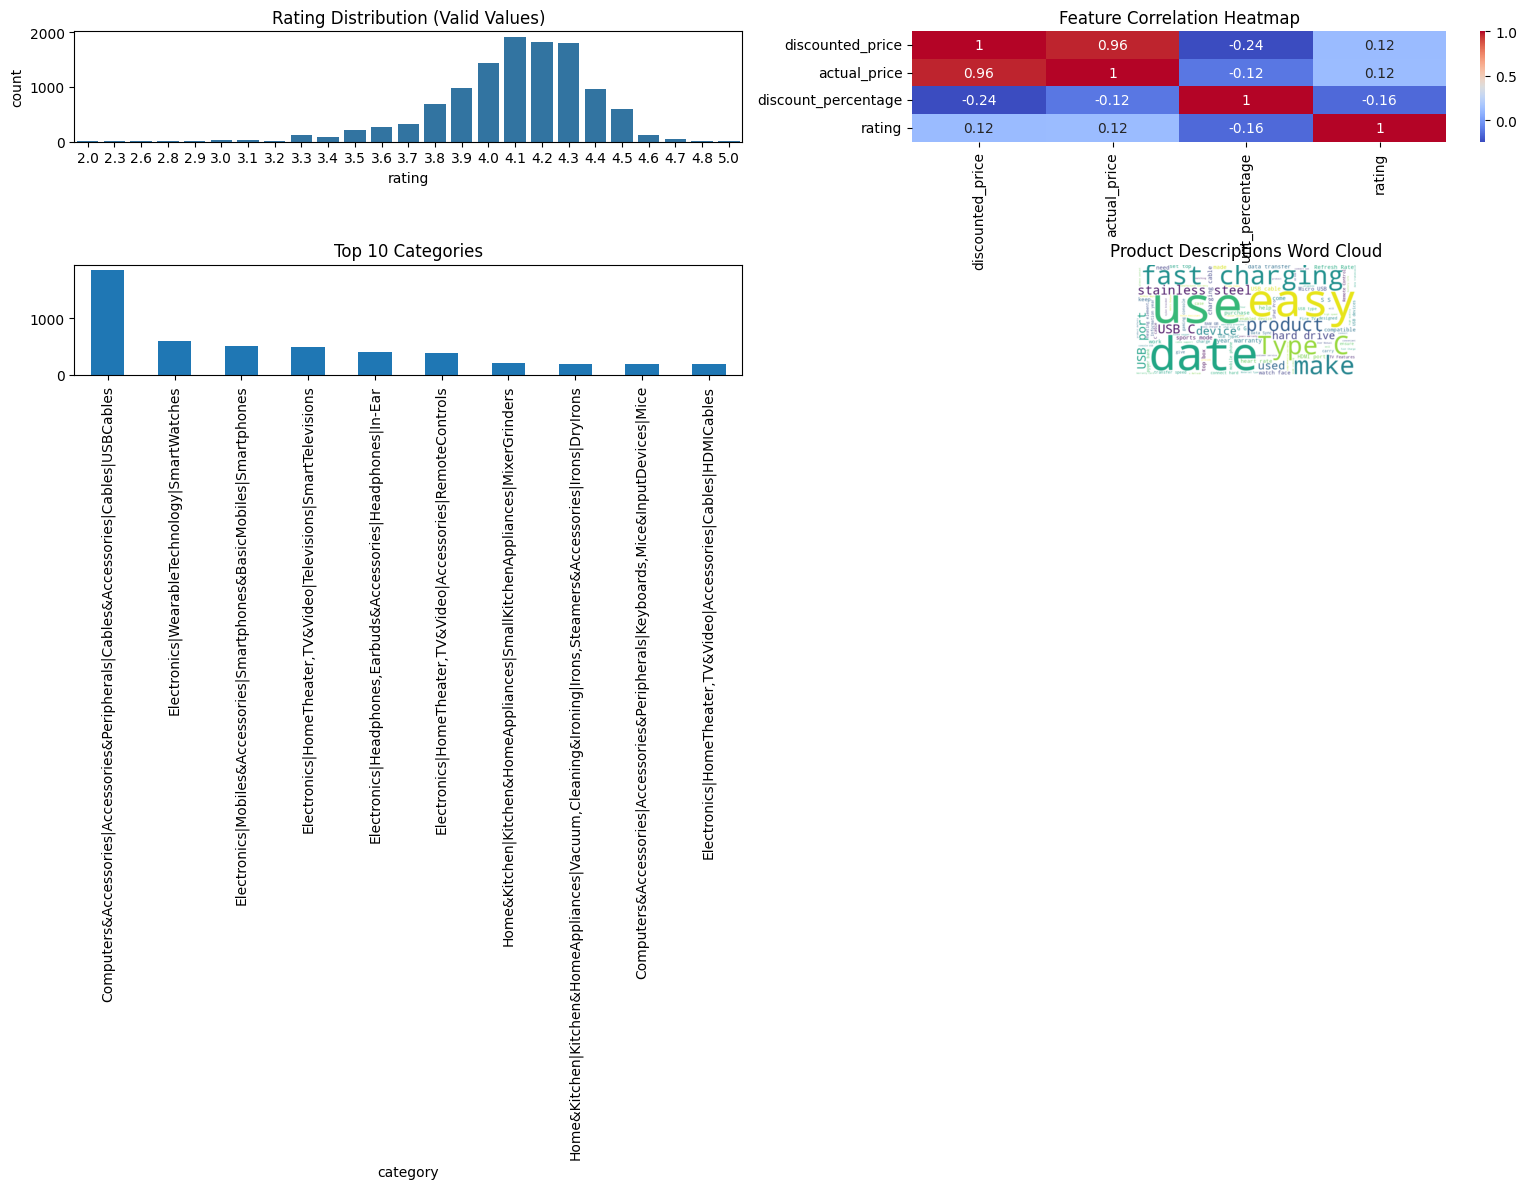

✅ EDA completed successfully


In [74]:
# EXECUTE THIS CELL TO RUN EDA
perform_eda(df)


In [76]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [77]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import logging
from sklearn.metrics import accuracy_score
from collections import defaultdict

# Initialize more advanced sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(df, text_column='review_content', sample_size=None):
    """
    Perform sentiment analysis with multiple methods and enhanced features
    Args:
        df: Input DataFrame
        text_column: Column containing text reviews
        sample_size: Number of samples to process (for testing)
    Returns:
        DataFrame with sentiment analysis results
    """
    try:
        # Validate input
        if text_column not in df.columns:
            raise ValueError(f"Column '{text_column}' not found in DataFrame")

        # Sample data if needed for testing
        if sample_size:
            df = df.sample(sample_size)

        # Text preprocessing
        df[text_column] = df[text_column].fillna('').astype(str)
        df['clean_text'] = df[text_column].str.lower()\
                                          .str.replace(r'[^\w\s]', '', regex=True)

        # TextBlob analysis
        df['tb_polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

        # VADER analysis (better for short texts)
        df['vader_score'] = df['clean_text'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

        # Combined sentiment scoring
        df['sentiment_score'] = (df['tb_polarity'] + df['vader_score']) / 2

        # Enhanced categorization with dynamic thresholds
        sentiment_bins = [-1, -0.25, 0.25, 1]
        sentiment_labels = ['Negative', 'Neutral', 'Positive']
        df['sentiment'] = pd.cut(df['sentiment_score'],
                                 bins=sentiment_bins,
                                 labels=sentiment_labels)

        # Generate visualizations
        plt.figure(figsize=(12, 6))

        # Sentiment distribution
        plt.subplot(1, 2, 1)
        sns.countplot(x='sentiment', data=df, order=sentiment_labels)
        plt.title('Sentiment Distribution')

        # Sentiment score distribution
        plt.subplot(1, 2, 2)
        sns.histplot(df['sentiment_score'], bins=20, kde=True)
        plt.title('Sentiment Score Distribution')

        plt.tight_layout()
        plt.show()

        # Add example reviews
        examples = defaultdict(list)
        for label in sentiment_labels:
            sample = df[df['sentiment'] == label].sample(1)
            examples[label].append({
                'review': sample[text_column].values[0],
                'score': sample['sentiment_score'].values[0]
            })

        print("\nSample Reviews:")
        for label, samples in examples.items():
            print(f"\n{label}:")
            for s in samples:
                print(f"Score: {s['score']:.2f}\nReview: {s['review'][:100]}...")

        # Calculate inter-method agreement
        agreement = accuracy_score(df['tb_polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'),
                                  df['vader_score'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral'))
        print(f"\nMethod agreement: {agreement*100:.1f}%")

        progress['sentiment'] = True
        logging.info("Sentiment analysis completed successfully")
        print("✅ Sentiment analysis completed")
        return df

    except Exception as e:
        progress['sentiment'] = False
        error_msg = f"Sentiment analysis failed: {str(e)}"
        logging.error(error_msg)
        print(f"❌ {error_msg}")
        return df

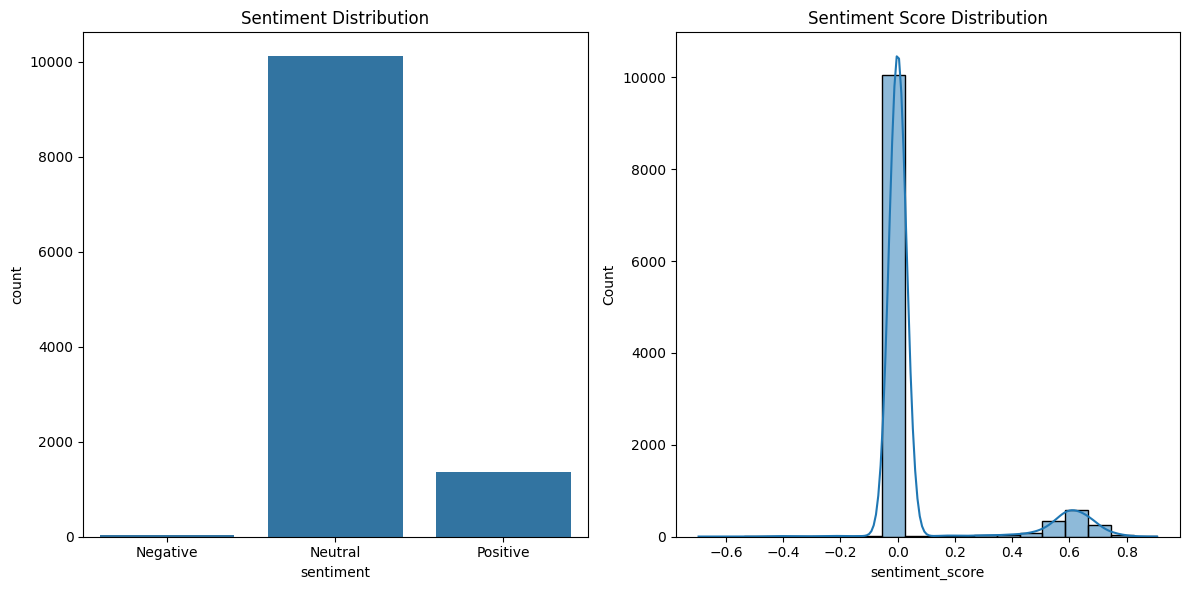


Sample Reviews:

Negative:
Score: -0.47
Review: It's been just a week ... So yet to know the performance overall but till date it's working fine,Goo...

Neutral:
Score: 0.00
Review: ...

Positive:
Score: 0.69
Review: Great product light weight n accuracy as of now good n easy to use.... must have in every kitchen,Th...

Method agreement: 99.4%
✅ Sentiment analysis completed


In [79]:
# EXECUTE THIS CELL TO RUN SENTIMENT ANALYSIS
df = analyze_sentiment(df)


In [96]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
progress = {'content_model': False, 'collab_model': False}

class RecommendationSystem:
    def __init__(self, df):
        self.df = df.copy()
        self.tfidf_matrix = None
        self.cosine_sim = None
        self.collab_model = None
        self.user_mapping = {}
        self.product_mapping = {}
        self.interactions = None

    def preprocess_text(self, text):
        """Preprocess product descriptions for content-based filtering"""
        return text.lower().replace('[^\w\s]', '').strip()

    def build_content_based(self, text_col='about_product'):
        """Build TF-IDF based content recommendation model"""
        try:
            # Preprocess text data
            self.df[text_col] = self.df[text_col].fillna('').apply(self.preprocess_text)

            # Create TF-IDF matrix
            tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
            self.tfidf_matrix = tfidf.fit_transform(self.df[text_col])

            # Calculate cosine similarity
            self.cosine_sim = cosine_similarity(self.tfidf_matrix)

            progress['content_model'] = True
            logging.info(f"Content model built with shape: {self.tfidf_matrix.shape}")
            print(f"✅ Content model built successfully with {self.tfidf_matrix.shape[0]} products")

        except Exception as e:
            progress['content_model'] = False
            logging.error(f"Content model error: {str(e)}")
            print(f"❌ Content model failed: {str(e)}")

    def get_content_recommendations(self, product_id, top_n=5):
        """Get content-based recommendations for a product"""
        try:
            if product_id not in self.df['product_id'].values:
                return {"error": "Product ID not found"}

            if self.cosine_sim is None:
                return {"error": "Content model not trained yet"}

            idx = self.df[self.df['product_id'] == product_id].index[0]
            sim_scores = list(enumerate(self.cosine_sim[idx]))

            # Sort and select top results
            sorted_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

            recommendations = []
            for i, score in sorted_scores:
                product = self.df.iloc[i]
                recommendations.append({
                    'product_id': product['product_id'],
                    'product_name': product['product_name'],
                    'category': product['category'],
                    'price': product['discounted_price'],
                    'similarity': round(score, 3)
                })

            return recommendations

        except Exception as e:
            logging.error(f"Recommendation error: {str(e)}")
            return []


    def build_collaborative_filtering(self, user_col='user_id', item_col='product_id', rating_col='rating'):
        """Build collaborative filtering model using LightFM"""
        try:
            # Validate required columns
            required = [user_col, item_col, rating_col]
            if not all(col in self.df.columns for col in required):
                raise ValueError(f"Missing required columns: {required}")

            # Preprocess interactions
            interactions_df = self.df[required].dropna()

            # Check for invalid user IDs
            if any(',' in str(uid) for uid in interactions_df[user_col]):
                raise ValueError("User IDs contain commas - preprocessing required")

            # Build LightFM dataset
            dataset = LightFMDataset()
            dataset.fit(
                users=interactions_df[user_col].unique(),
                items=interactions_df[item_col].unique()
            )

            # Create interactions matrix
            (self.interactions, _) = dataset.build_interactions(
                [(row[user_col], row[item_col], row[rating_col])
                 for _, row in interactions_df.iterrows()]
            )

            # Train model with WARP loss
            self.collab_model = LightFM(loss='warp', no_components=30)
            self.collab_model.fit(self.interactions, epochs=30, verbose=True)

            # Create ID mappings
            self.user_mapping = dataset.mapping()[0]
            self.product_mapping = dataset.mapping()[2]

            progress['collab_model'] = True
            logging.info(f"Collaborative model trained with {self.interactions.getnnz()} interactions")
            print(f"✅ Collaborative model built successfully with {len(self.user_mapping)} users")

        except Exception as e:
            progress['collab_model'] = False
            logging.error(f"Collaborative model error: {str(e)}")
            print(f"❌ Collaborative model failed: {str(e)}")

    def get_collab_recommendations(self, user_id, top_n=5):
        """Get collaborative filtering recommendations for a user"""
        try:
            if not self.collab_model:
                return {"error": "Model not trained yet"}

            if user_id not in self.user_mapping:
                return {"error": "User ID not found"}

            user_idx = self.user_mapping[user_id]
            scores = self.collab_model.predict(
                user_idx,
                np.arange(len(self.product_mapping)),
                num_threads=4
            )

            # Get top recommendations
            top_items = np.argsort(-scores)[:top_n]
            recommendations = []
            for idx in top_items:
                product_id = list(self.product_mapping.keys())[idx]
                product = self.df[self.df['product_id'] == product_id].iloc[0]
                recommendations.append({
                    'product_id': product_id,
                    'product_name': product['product_name'],
                    'category': product['category'],
                    'price': product['discounted_price'],
                    'predicted_score': round(scores[idx], 2)
                })

            return recommendations

        except Exception as e:
            logging.error(f"Recommendation error: {str(e)}")
            return []

    def evaluate_model(self, test_size=0.2):
        """Evaluate collaborative filtering model performance"""
        try:
            from lightfm.evaluation import precision_at_k

            if not self.collab_model:
                raise ValueError("Model not trained yet")

            # Split data
            interactions = self.interactions
            train = interactions[:int((1-test_size)*interactions.shape[0])]
            test = interactions[int((1-test_size)*interactions.shape[0]):]

            # Calculate precision@k
            precision = precision_at_k(self.collab_model, test, train, k=5).mean()
            print(f"Precision@5: {precision:.2f}")
            return precision

        except Exception as e:
            logging.error(f"Evaluation error: {str(e)}")
            return 0.0

In [97]:
# EXECUTE THESE CELLS TO BUILD RECOMMENDATION MODELS
rec_sys = RecommendationSystem(df)
rec_sys.build_content_based()
rec_sys.build_collaborative_filtering()


✅ Content model built successfully with 11503 products


Epoch: 100%|██████████| 30/30 [00:00<00:00, 42.47it/s]

✅ Collaborative model built successfully with 9050 users


In [98]:
print("🔍 Collaborative Filtering Diagnostic")
print("----------------------------------")

if not hasattr(rec_sys, 'collab_model') or rec_sys.collab_model is None:
    print("❌ Model not trained. Please run build_collaborative_filtering() first")
else:
    print("Model detected. Checking data...")
    if rec_sys.interactions is None:
        print("❌ Interaction matrix not found. Check build_collaborative_filtering() execution")
    else:
        print(f"✅ Found {rec_sys.interactions.shape[0]} interactions")
        print(f"   Users: {len(rec_sys.user_mapping)}")
        print(f"   Products: {len(rec_sys.product_mapping)}")

        # Check sample user
        if rec_sys.user_mapping:
            sample_user = next(iter(rec_sys.user_mapping))
            print(f"\nTesting recommendations for user {sample_user}:")
            print(rec_sys.get_collab_recommendations(sample_user, top_n=3))
        else:
            print("❌ No valid users found in mappings")

🔍 Collaborative Filtering Diagnostic
----------------------------------
Model detected. Checking data...
✅ Found 9050 interactions
   Users: 9050
   Products: 1351

Testing recommendations for user AG3D6O4STAQKAY2UVGEUV46KN35Q:
[{'product_id': 'B07JW9H4J1', 'product_name': 'Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)', 'category': 'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables', 'price': np.float64(399.0), 'predicted_score': np.float32(2.6)}, {'product_id': 'B07JH1C41D', 'product_name': 'Wayona Nylon Braided (2 Pack) Lightning Fast Usb Data Cable Fast Charger Cord For Iphone, Ipad Tablet (3 Ft Pack Of 2, Grey)', 'category': 'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables', 'price': np.float64(649.0), 'predicted_score': np.float32(2.28)}, {'product_id': 'B07LGT55SJ', 'product_name': 'Wayona Usb Nylon

In [99]:
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
from wordcloud import WordCloud
import base64
from io import BytesIO
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate

def create_dashboard(df, rec_sys):
    # Validate required columns
    required_columns = ['category', 'discounted_price', 'rating', 'sentiment', 'about_product']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {set(required_columns) - set(df.columns)}")

    app = dash.Dash(__name__,
                   external_stylesheets=[dbc.themes.BOOTSTRAP],
                   meta_tags=[{'name': 'viewport', 'content': 'width=device-width, initial-scale=1'}])

    # Precompute word cloud for performance
    def make_wordcloud(data):
        if data.empty:
            return ""
        wc = WordCloud(background_color='white').generate(' '.join(data))
        img = wc.to_image()
        img_buffer = BytesIO()
        img.save(img_buffer, format='PNG')
        return 'data:image/png;base64,{}'.format(base64.b64encode(img_buffer.getvalue()).decode())

    # Initial word cloud
    initial_wc = make_wordcloud(df['about_product'].dropna())

    app.layout = dbc.Container([
        dbc.Row([
            dbc.Col(html.H1("Amazon Product Dashboard", className="mb-4"), width=12)
        ]),

        dbc.Row([
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("Filters"),
                    dbc.CardBody([
                        dcc.Dropdown(
                            id='category-filter',
                            options=[{'label': c, 'value': c} for c in df['category'].unique()],
                            placeholder="Select Category",
                            multi=True
                        ),
                        dcc.RangeSlider(
                            id='price-slider',
                            min=0,
                            max=df['discounted_price'].max(),
                            value=[df['discounted_price'].min(), df['discounted_price'].quantile(0.95)],
                            marks={0: '₹0', df['discounted_price'].max(): f'₹{df["discounted_price"].max():.0f}'},
                            tooltip={"placement": "bottom", "always_visible": True}
                        )
                    ])
                ], className="mb-4")
            ], width=3),

            dbc.Col([
                dbc.Row([
                    dbc.Col(dcc.Graph(id='rating-plot'), width=6),
                    dbc.Col(dcc.Graph(id='price-plot'), width=6)
                ]),
                dbc.Row([
                    dbc.Col(dcc.Graph(id='sentiment-plot'), width=6),
                    dbc.Col(html.Img(id='wordcloud', src=initial_wc), width=6)
                ])
            ], width=9)
        ]),

        dbc.Row([
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("Recommendations"),
                    dbc.CardBody([
                        dbc.InputGroup([
                            dbc.Input(id='product-input', placeholder='Product ID'),
                            dbc.Button("Content Recs", id='content-btn', color="primary")
                        ], className="mb-3"),
                        dbc.InputGroup([
                            dbc.Input(id='user-input', placeholder='User ID'),
                            dbc.Button("Collab Recs", id='collab-btn', color="success")
                        ]),
                        html.Div(id='recs-output')
                    ])
                ])
            ], width=12)
        ])
    ], fluid=True)

    # Memoization for word cloud
    @app.callback(
        Output('wordcloud', 'src'),
        Input('category-filter', 'value'),
        Input('price-slider', 'value'),
        prevent_initial_call=True
    )
    def update_wordcloud(categories, price_range):
        filtered = df.copy()
        if categories:
            filtered = filtered[filtered['category'].isin(categories)]
        filtered = filtered[
            (filtered['discounted_price'] >= price_range[0]) &
            (filtered['discounted_price'] <= price_range[1])
        ]
        return make_wordcloud(filtered['about_product'].dropna())

    # Debounced updates for plots
    @app.callback(
        [Output('rating-plot', 'figure'),
         Output('price-plot', 'figure'),
         Output('sentiment-plot', 'figure')],
        [Input('category-filter', 'value'),
         Input('price-slider', 'value')],
        prevent_initial_call=True
    )
    def update_plots(categories, price_range):
        filtered = df.copy()
        if categories:
            filtered = filtered[filtered['category'].isin(categories)]
        filtered = filtered[
            (filtered['discounted_price'] >= price_range[0]) &
            (filtered['discounted_price'] <= price_range[1])
        ]

        # Rating distribution
        rating_fig = px.histogram(filtered, x='rating', nbins=10,
                                 title='Rating Distribution',
                                 color_discrete_sequence=['#636EFA'])

        # Price vs Rating
        price_fig = px.scatter(filtered, x='discounted_price', y='rating',
                              color='discount_percentage',
                              title='Price vs Rating',
                              color_continuous_scale='Blues')

        # Sentiment
        sentiment_fig = px.pie(filtered, names='sentiment',
                              title='Sentiment Distribution',
                              color_discrete_sequence=px.colors.sequential.Blues)

        return [rating_fig, price_fig, sentiment_fig]

    # Recommendations with error handling
    @app.callback(
        Output('recs-output', 'children'),
        [Input('content-btn', 'n_clicks'),
         Input('collab-btn', 'n_clicks')],
        [State('product-input', 'value'),
         State('user-input', 'value')],
        prevent_initial_call=True
    )
    def show_recommendations(content_clicks, collab_clicks, product_id, user_id):
        ctx = dash.callback_context
        if not ctx.triggered:
            raise PreventUpdate

        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

        try:
            if button_id == 'content-btn':
                if not product_id:
                    return dbc.Alert("Please enter a Product ID", color="danger")
                recs = rec_sys.get_content_recommendations(product_id)
                return dbc.Table.from_dataframe(pd.DataFrame(recs), striped=True, bordered=True)

            if button_id == 'collab-btn':
                if not user_id:
                    return dbc.Alert("Please enter a User ID", color="danger")
                recs = rec_sys.get_collab_recommendations(user_id)
                return dbc.Table.from_dataframe(pd.DataFrame(recs), striped=True, bordered=True)

        except Exception as e:
            return dbc.Alert(f"Error: {str(e)}", color="danger")

    return app

In [100]:
!pip install dash dash-bootstrap-components pandas plotly wordcloud

In [101]:
# EXECUTE THIS CELL TO LAUNCH DASHBOARD
app = create_dashboard(df, rec_sys)
print("\n🚀 Starting Dashboard on http://localhost:8050")
app.run(debug=False, port=8050)  # Updated method name


🚀 Starting Dashboard on http://localhost:8050


<IPython.core.display.Javascript object>